This notebook recreates Figure 1 from Merdith et al. (2019). It extracts spreading rate data from plate models and plots the full distirbtuion normalised by segment length. This script was written by Suzanne Atkins (suzanne.atkins@ens.fr, github.com/seatkins). The script is general and so *should* be reasonably easy to use for any time period/ocean basin/plate model.

References

Merdith, A.S., Atkins, S.E., and Tetley, M.G. (accepted for publication). Tectonic controls on carbon and serpentinite storage in subducted upper oceanic lithosphere for the past 320 Ma. Frontiers: Earth Science.

In [1]:
import numpy as np
import pygplates
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
import pickle
import math
from spreading_rate import spread_rate


In [3]:
#setbasedir for loading reconstruction files
basedir = '/Users/Andrew/Documents/GitHub/pyGPlates_examples/Merdith_2019_Frontiers/Sample_data/'
basedir_save = '/Users/Andrew/Documents/GitHub/pyGPlates_examples/Merdith_2019_Frontiers/output/'

#load rotation files
rotfile = '%s/Matthews_etal_GPC_2016_410-0Ma_GK07.rot' % basedir
topology_features = ['%s/Matthews_etal_GPC_2016_MesozoicCenozoic_PlateTopologies.gpmlz' % basedir,
              '%s/Matthews_etal_GPC_2016_Paleozoic_PlateTopologies.gpmlz' % basedir]

rotation_model = pygplates.RotationModel(rotfile)

So this script works by setting up empty arrays of size (timesteps, spreading rate range). That is, we want an array that at each timestep has a bin for each spreading rate rounded to the nearest cm. This means we need to  now max spreading rate before starting. This is (was) a bit of trial and error and depends on the time range and which basin is being analysed. We found 56 cm/a was necessary for all ocean basins back to 400 Ma in the Matthews model. But if you are only looking at the last 200 Ma then a smaller number can be used.

Because in this study we wanted to differentiate between plates found in the pacific ocean basin and those in other ocean basins (i.e. external vs internal oceans) we compiled a list of plateIDs that correspond to ridges  preading in the Pacific Ocean (see text of paper for details). We can use this list to either find just ridges in the pacific, ridges not in the pacific or all ridges.

In [8]:
#set start and end times
enq_time = 200
str_time = 0

#set empty arrays to store results
basin_ridge_length = np.zeros([enq_time-str_time+1])

#initiate arrays for results
spread_mean = np.zeros([enq_time-str_time+1,3])
spread_std = np.zeros([enq_time-str_time+1,3])

#these store the results of interest
spread_dist = np.zeros([enq_time-str_time+1,56])
spread_distn = np.zeros([enq_time-str_time+1,56])


#define plate IDs of ridges of interest (pacific ridges in this case)
plates = np.r_[608,653,659,699,824,847,901,902,903,904,908,908,909,911,\
               918,919,925,926,971,982,983,985,2035,\
               609,688,689,918,732,780,678,919]


for time in np.arange(str_time,enq_time+1,1):
    print (time)
    #resolve topologies for time interval
    resolved_topologies = []
    shared_boundary_sections = []
    pygplates.resolve_topologies(topology_features, rotation_model, resolved_topologies, int(time), shared_boundary_sections)
    
    k=0
    vel = np.zeros([0])
    vel2 = np.zeros([0])
    vel3 = np.zeros([0])
    seg_len = np.zeros([0])

    for boundary_section in shared_boundary_sections:
        k+=1
        #loop through boundary sections to get ridges
        if boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_mid_ocean_ridge:
            
            #here we can differentiate between external, internal and all oceans.
            #currently the scrip is set up for all oceans.
            
            #if boundary_section.get_feature().get_left_plate() in plates and\
            #            boundary_section.get_feature().get_right_plate() in plates:
            
            #get length of the segment
            basin_ridge_length[time-str_time]+=pygplates.Earth.mean_radius_in_kms*boundary_section.get_topological_section_geometry().get_arc_length()
            
            #get velocity
            vela,velpl,vels,vel_min_max,shd_len,seg_len1,seg_plate_id1=spread_rate(boundary_section,rotation_model,int(time))

            vel = np.concatenate([vel,vels]) # velocity weighted by segment length for true mean
            vel2 = np.concatenate([vel2,vela]) # velocity of each segment
            vel3 = np.concatenate([vel3,velpl]) # velocity/segment length
            seg_len = np.concatenate([seg_len,seg_len1]) # segment length

    #Finding distribution of velocities
    #We loop through our velocity segments and each velocity is rounded down
    #This has the practical effect of binning our data
    for i in range(0,vel2.shape[0]):
        aaa = math.floor(vel2[i])#rounds down the spreading rate for a segment
        spread_dist[time-str_time,int(aaa)]+=seg_len[i]
   
    #get the results
    spread_distn[(time-str_time),::] = spread_dist[time-str_time,::]/sum(seg_len).copy()#this is what we want
    spread_mean[time-str_time,0] = np.sum(vel[::])/basin_ridge_length[time-str_time] # global mean spreading velocity 
    spread_mean[time-str_time,1] = np.mean(vel2[::]) # mean velocity of any segment
    spread_mean[time-str_time,2] = np.mean(vel3[::]) # mean velocity per segment length

    spread_std[time-str_time,0] = (sum(((vel2[::]-spread_mean[time-str_time,0])**2)*seg_len[::])/(sum(seg_len[::])))**0.5 # global std of  velocity
    spread_std[time-str_time,1] = np.std(vel2[::]) # std of segment velocity
    spread_std[time-str_time,2] = np.std(vel3[::]) # std of velocity per length

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


In [33]:
spread_mean

array([[2.56708242, 6.2788517 , 1.6877132 ],
       [2.57350107, 4.04664327, 0.1329055 ],
       [2.62398517, 3.78376145, 0.0945118 ],
       [2.68556435, 3.81688141, 0.09023153],
       [2.68299748, 3.8911268 , 0.09501615],
       [2.77730353, 4.02627804, 0.13618205],
       [2.81933182, 3.86700537, 0.19972182],
       [2.74291328, 3.81029084, 0.19272701],
       [2.77310245, 3.86918872, 0.70521827],
       [2.76118766, 3.84358568, 0.21721207],
       [2.87424007, 3.81879778, 0.12606596],
       [2.80578527, 3.98763651, 0.21744429],
       [2.82353307, 4.01570004, 0.22043328],
       [2.94631454, 4.1979961 , 0.24886006],
       [2.9187569 , 4.1748734 , 0.2317645 ],
       [3.03148685, 4.13545942, 0.26692461],
       [3.17236936, 4.12255732, 0.16433675],
       [3.14307645, 4.08419136, 0.18180694],
       [3.18593572, 4.13144675, 0.2160457 ],
       [3.15697762, 4.12628155, 0.1583218 ],
       [2.97821193, 4.0083972 , 0.45827851],
       [3.06802565, 3.99980872, 0.0907956 ],
       [3.

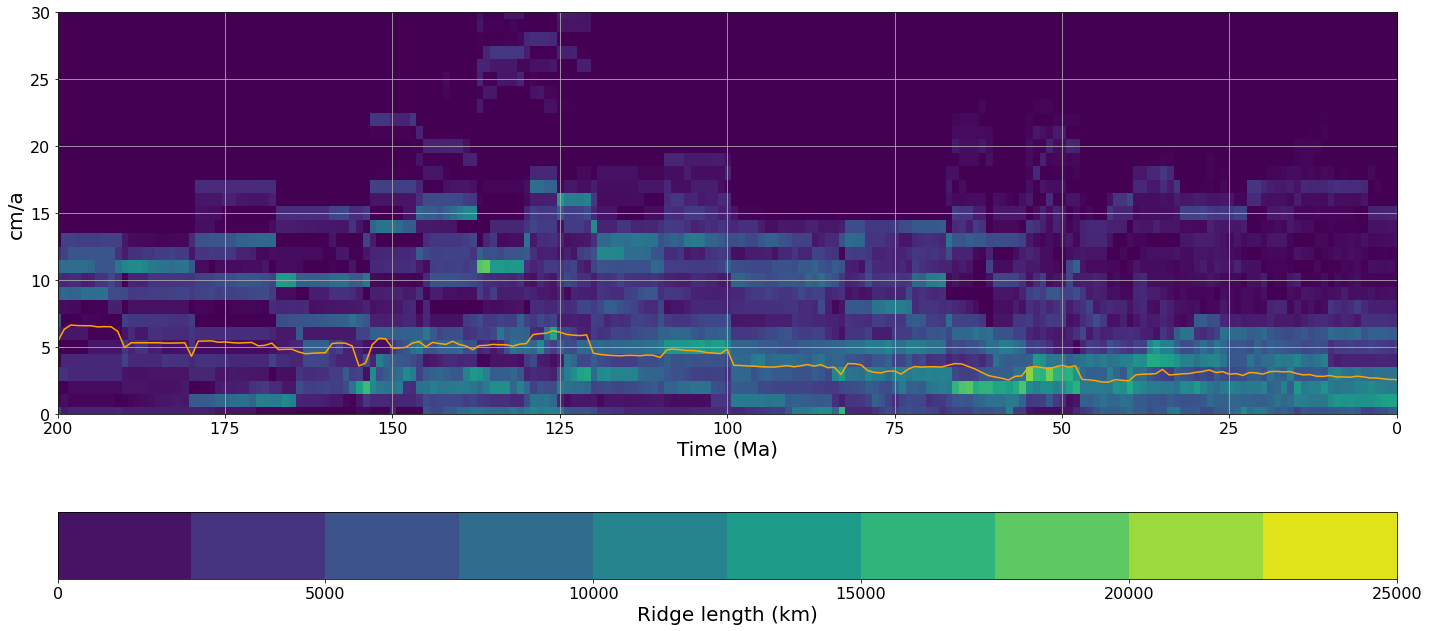

In [41]:
#time to plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(24,12))
#set vmax to 25000
im = ax.imshow(spread_dist.T,interpolation='none',aspect=2,vmin=0, vmax=25000)

#lots of axis stuff sorry :/
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_ylim(0, 30)
ax.set_xlim(200,str_time)
ax.set_ylabel('cm/a', fontsize=20)
ax.set_xlabel('Time (Ma)', fontsize=20)
ax.tick_params(axis='both', labelsize=16)
ax.plot(spread_mean[:,0], c='orange')
cbar=fig.colorbar(im, ax=ax, boundaries=np.linspace(0, 25000, 11), orientation='horizontal')
cbar.set_label('Ridge length (km)', fontsize=20)
cbar.ax.tick_params(labelsize=16)

#ax.axhline(2,c='white',linewidth=4)#this is the cutoff in our model for tectonic vs. magmatic accretion
ax.grid()

#to save
#plt.savefig('%s/All_spreading_rates_400_0.pdf' % savedir)


In [ ]:
# to save the distribution as a pickle file 
#output_spread_distn = np.sort(spreading_dist)
#pickle.dump(output_spread_distn,open('%s/Spreading_distribution_All_%s_Ma.p' % (basedir, enq_time),'wb'))